### Re-visit the OpenSoundScape CNN model training process. 


- So far we've built a training dataset containing human tags of the target species, and inferrred a set of negative samples. 
- These samples still need some human verification to remove mis-labelled samples. 
- This notebook attempts to use OpenSoundScape's methods for training.

In [1]:
# !pip install wandb
# ! pip install wandb --upgrade

In [1]:
%env PYTORCH_ENABLE_MPS_FALLBACK 0

env: PYTORCH_ENABLE_MPS_FALLBACK=0


In [2]:
# autoreload
%load_ext autoreload
%autoreload 2

In [3]:
!env |grep MPS


PYTORCH_ENABLE_MPS_FALLBACK=0


In [4]:
!wandb login

wandb: Currently logged in as: mgallimore88. Use `wandb login --relogin` to force relogin


In [5]:
# imports
from pathlib import Path
import sys
import pandas as pd
BASE_PATH = Path.cwd().parent.parent
sys.path.append(str(BASE_PATH))
from src.utils import display_all, plot_locations, keep_cols
import src.data
import src.data.build
import opensoundscape as opso
from opensoundscape.preprocess.utils import show_tensor, show_tensor_grid
import torch

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/ml/cnn.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [6]:
# load the raw data
data_path = Path.cwd().parent.parent / "data"
train_df_path = Path.cwd().parent.parent / "data" / "processed" / "train_set"
df_train = pd.read_pickle(train_df_path / "train_set.pkl")

70 not downloaded
downloading 0 clips
skipped 0 previously downloaded files

--------------------------------------------------
before filtering undefined clips
recordings per task method = 
 task_method
1SPT    207551
1SPM     74805
None     44385
Name: count, dtype: int64
total recordings = 326741

Tags generated from each tagging method:
             target_presence  target_absence
task_method                                 
1SPM                  2009.0         13236.0
1SPT                  2483.0         38530.0
NaN                    762.0          3262.0
total target clips =  5254
total absence clips =  55028
total available human labelled target tags = 4204
undefined 266459

--------------------------------------------------
after filtering undefined clips
recordings per task method = 
 task_method
1SPT    41013
1SPM    15245
None     4024
Name: count, dtype: int64
total recordings = 60282

Tags generated from each tagging method:
             target_presence  target_absence
ta

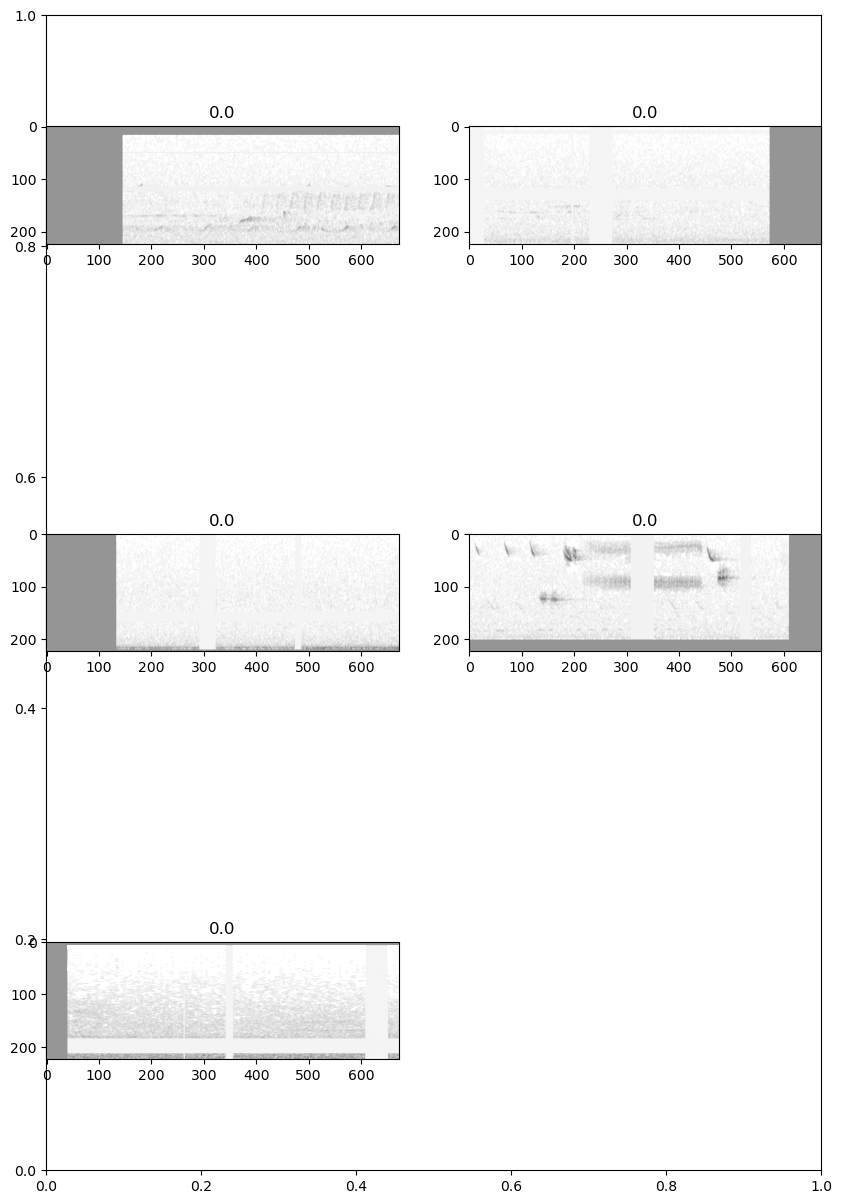

In [7]:
train_dataset, valid_dataset, _, _ = src.data.build.dataset_from_df(df_train, target_species = "OSFL", download_n=0)

In [8]:
train_df = train_dataset.label_df
valid_df = valid_dataset.label_df

In [9]:
train_df.target_presence.value_counts(), valid_df.target_presence.value_counts()

(target_presence
 0.0    45870
 1.0     4267
 Name: count, dtype: int64,
 target_presence
 0.0    9158
 1.0     987
 Name: count, dtype: int64)

In [10]:
from opensoundscape.data_selection import resample

# upsample (repeat samples) or downsample so that all classes have 800 samples
balanced_train_df = resample(train_df,n_samples_per_class=800,random_state=0)

In [11]:
balanced_train_df.target_presence.value_counts(), len(balanced_train_df)

(target_presence
 1.0    800
 0.0    800
 Name: count, dtype: int64,
 1600)

In [28]:
# Create a CNN object designed to recognize 3-second samples
from opensoundscape import CNN

# Use resnet18 or resnet34 architecture
architecture = 'resnet34'

# Can use this code to get your classes, if needed
class_list = list(train_df.columns)

model = CNN(
    architecture = architecture,
    classes = class_list,
    sample_duration=3,
)
model.single_target = True


In [29]:
model.network.fc

Linear(in_features=512, out_features=2, bias=True)

In [30]:
class_list

['target_presence', 'target_absence']

In [31]:
print(f'model.device is: {model.device}')

model.device is: mps


In [32]:
import wandb
wandb.login()

wandb_session = wandb.init(

    project='osfl',
    config={
    "epochs":6,
    "log_histograms":False,
    }
)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


In [33]:
balanced_train_df

,,,target_presence,target_absence
file,start_time,end_time,,
../../data/raw/recordings/OSFL/recording-294837.mp3,42.0,45.0,1.0,0.0
../../data/raw/recordings/OSFL/recording-218383.flac,46.5,49.5,1.0,0.0
../../data/raw/recordings/OSFL/recording-297209.mp3,24.0,27.0,1.0,0.0
../../data/raw/recordings/OSFL/recording-552529.flac,4.5,7.5,1.0,0.0
../../data/raw/recordings/OSFL/recording-294751.mp3,13.5,16.5,1.0,0.0
...,...,...,...,...
../../data/raw/recordings/OSFL/recording-577634.flac,36.0,39.0,0.0,1.0
../../data/raw/recordings/OSFL/recording-293178.mp3,78.0,81.0,0.0,1.0
../../data/raw/recordings/OSFL/recording-553708.flac,6.0,9.0,0.0,1.0


In [34]:
model.train(
    balanced_train_df,
    valid_df,
    epochs = 6,
    batch_size = 64,
    num_workers = 4, #4 parallelized cpu tasks for preprocessing
    wandb_session = wandb_session,
    )


Training Epoch 0


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 0 [batch 0/25, 0.00%] 
	DistLoss: 0.743
Metrics:


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)


Epoch: 0 [batch 10/25, 40.00%] 
	DistLoss: 0.727
Metrics:
Epoch: 0 [batch 20/25, 80.00%] 
	DistLoss: 0.715
Metrics:
Metrics:

Validation.


  0%|          | 0/159 [00:00<?, ?it/s]

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)


Metrics:

Training Epoch 1


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 1 [batch 0/25, 0.00%] 
	DistLoss: 0.713


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)


Metrics:


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)


Epoch: 1 [batch 10/25, 40.00%] 
	DistLoss: 0.707
Metrics:
Epoch: 1 [batch 20/25, 80.00%] 
	DistLoss: 0.708
Metrics:
Metrics:

Validation.


  0%|          | 0/159 [00:00<?, ?it/s]

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)


Metrics:

Training Epoch 2


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 2 [batch 0/25, 0.00%] 
	DistLoss: 0.703
Metrics:


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)


Epoch: 2 [batch 10/25, 40.00%] 
	DistLoss: 0.702
Metrics:
Epoch: 2 [batch 20/25, 80.00%] 
	DistLoss: 0.706
Metrics:
Metrics:

Validation.


  0%|          | 0/159 [00:00<?, ?it/s]

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)


Metrics:

Training Epoch 3


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 3 [batch 0/25, 0.00%] 
	DistLoss: 0.701


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)


Metrics:


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)


Epoch: 3 [batch 10/25, 40.00%] 
	DistLoss: 0.705
Metrics:
Epoch: 3 [batch 20/25, 80.00%] 
	DistLoss: 0.703
Metrics:
Metrics:

Validation.


  0%|          | 0/159 [00:00<?, ?it/s]

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)


Metrics:

Training Epoch 4


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 4 [batch 0/25, 0.00%] 
	DistLoss: 0.854


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)


Metrics:
Epoch: 4 [batch 10/25, 40.00%] 
	DistLoss: 0.736
Metrics:


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)


Epoch: 4 [batch 20/25, 80.00%] 
	DistLoss: 0.737
Metrics:
Metrics:

Validation.


  0%|          | 0/159 [00:00<?, ?it/s]

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)


Metrics:

Training Epoch 5


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 5 [batch 0/25, 0.00%] 
	DistLoss: 0.688
Metrics:


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)


Epoch: 5 [batch 10/25, 40.00%] 
	DistLoss: 0.696
Metrics:
Epoch: 5 [batch 20/25, 80.00%] 
	DistLoss: 0.696
Metrics:
Metrics:

Validation.


  0%|          | 0/159 [00:00<?, ?it/s]

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)


Metrics:

Best Model Appears at Epoch 0 with Validation score 0.949.


In [35]:

model.train(
    balanced_train_df,
    valid_df,
    epochs = 2,
    batch_size = 64,
    log_interval = 100, #log progress every 100 batches
    num_workers = 4, #4 parallelized cpu tasks for preprocessing
    save_interval = 10, #save checkpoint every 10 epochs
)


Training Epoch 6


  0%|          | 0/25 [00:00<?, ?it/s]

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)


Epoch: 6 [batch 0/25, 0.00%] 
	DistLoss: 0.634
Metrics:


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)


Metrics:

Validation.


  0%|          | 0/159 [00:00<?, ?it/s]

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)


Metrics:

Training Epoch 7


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 7 [batch 0/25, 0.00%] 
	DistLoss: 0.698
Metrics:


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)


Metrics:

Validation.


  0%|          | 0/159 [00:00<?, ?it/s]

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)


Metrics:

Best Model Appears at Epoch 6 with Validation score 0.949.


The resnet34 took 3m30 and didn't converge. The resnet18 took 2m 41 and didn't converge. 
The similarity in training time between different sized architectures suggests that most of the time is spent making spectrograms on the fly.

Looking at the plots on Weights and Biases, I can see that the model is overfitting to the specifics of the training set without any improvement on the validation set during training. 

For some reason validation_loss isn't plotted by weights and biases. Look for a way of plotting this

Next steps:

Try to train a model using precomputed spectrograms:

1. Get all of the recordings from the training dataset downloaded (Only using half of them at this stage).
2. Try using the opensoundscape resample loss.
3. Precompute spectrograms from the downloaded audio and save them into 2 folders. Choose a sample from the no_call sections
4. Use these as training, validation and test data to train a model using the fastai framework. 

In [40]:
model.loss_hist

{0: 0.7151592,
 1: 0.70560485,
 2: 0.7087473,
 3: 0.71182,
 4: 0.74260056,
 5: 0.6989925,
 6: 0.71470064,
 7: 0.7171962}

In [49]:
model.valid_metrics

{0: {'confusion_matrix': array([[   0,  987],
         [   0, 9158]]),
  'precision': 0.9027106949236077,
  'recall': 1.0,
  'f1': 0.9488680515981972,
  'jaccard': 0.45135534746180384,
  'hamming_loss': 0.09728930507639232},
 1: {'confusion_matrix': array([[   0,  987],
         [   0, 9158]]),
  'precision': 0.9027106949236077,
  'recall': 1.0,
  'f1': 0.9488680515981972,
  'jaccard': 0.45135534746180384,
  'hamming_loss': 0.09728930507639232},
 2: {'confusion_matrix': array([[   0,  987],
         [   0, 9158]]),
  'precision': 0.9027106949236077,
  'recall': 1.0,
  'f1': 0.9488680515981972,
  'jaccard': 0.45135534746180384,
  'hamming_loss': 0.09728930507639232},
 3: {'confusion_matrix': array([[   0,  987],
         [   0, 9158]]),
  'precision': 0.9027106949236077,
  'recall': 1.0,
  'f1': 0.9488680515981972,
  'jaccard': 0.45135534746180384,
  'hamming_loss': 0.09728930507639232},
 4: {'confusion_matrix': array([[   0,  987],
         [   0, 9158]]),
  'precision': 0.902710694923

In [51]:
model.save("osfl_model")

In [37]:
train_dataset.class_counts()
valid_dataset.class_counts()

(Index(['target_presence', 'target_absence'], dtype='object'),
 array([ 987., 9158.]))

In [38]:
model.network.fc

Linear(in_features=512, out_features=2, bias=True)

# Make predictions on the validation set
http://opensoundscape.org/en/latest/tutorials/predict_with_cnn.html

In [68]:
from opensoundscape.ml.cnn import load_model
# Other utilities and packages
import torch
from pathlib import Path
import numpy as np
import pandas as pd
from glob import glob
import subprocess

In [69]:


#set up plotting
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=[15,5] #for large visuals
%config InlineBackend.figure_format = 'retina'


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/matplotlib_inline/config.py:68: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):


In [70]:
torch.hub.list('kitzeslab/bioacoustics-model-zoo')

Using cache found in /Users/mikeg/.cache/torch/hub/kitzeslab_bioacoustics-model-zoo_main


['BirdNET', 'Perch', 'SeparationModel', 'YAMNet', 'rana_sierrae_cnn']

In [75]:
valid_dataset.label_df

target_presence  \
file                                               start_time end_time                    
../../data/raw/recordings/OSFL/recording-4454.mp3  1.5        4.5                   1.0   
                                                   3.0        6.0                   1.0   
                                                   60.0       63.0                  1.0   
                                                   93.0       96.0                  1.0   
                                                   118.5      121.5                 1.0   
...                                                                                 ...   
../../data/raw/recordings/OSFL/recording-826104... 6.0        9.0                   0.0   
                                                   7.5        10.5                  0.0   
                                                   9.0        12.0                  0.0   
                                                   10.5       13.5                  0.0   
                                                   13.5       16.5                  1.0   

                                                                        target_absence  
file                                               start_time end_time                  
../../data/raw/recordings/OSFL/recording-4454.mp3  1.5        4.5                  0.0  
                                                   3.0        6.0                  0.0  
                                                   60.0       63.0                 0.0  
                                                   93.0       96.0                 0.0  
                                                   118.5      121.5                0.0  
...                                                                                ...  
../../data/raw/recordings/OSFL/recording-826104... 6.0        9.0                  1.0  
                                                   7.5        10.5                 1.0  
                                                   9.0        12.0                 1.0  
                                                   10.5       13.5                 1.0  
                                                   13.5       16.5                 0.0  

[10145 rows x 2 columns]

In [76]:
model.predict(valid_dataset.label_df)

  0%|          | 0/10145 [00:00<?, ?it/s]

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)


target_presence  \
file                                               start_time end_time                    
../../data/raw/recordings/OSFL/recording-4454.mp3  1.5        4.5              0.356499   
                                                   3.0        6.0              0.356499   
                                                   60.0       63.0             0.356499   
                                                   93.0       96.0             0.356499   
                                                   118.5      121.5            0.356499   
...                                                                                 ...   
../../data/raw/recordings/OSFL/recording-826104... 6.0        9.0              0.356499   
                                                   7.5        10.5             0.356499   
                                                   9.0        12.0             0.356499   
                                                   10.5       13.5             0.356499   
                                                   13.5       16.5             0.356499   

                                                                        target_absence  
file                                               start_time end_time                  
../../data/raw/recordings/OSFL/recording-4454.mp3  1.5        4.5            -0.464677  
                                                   3.0        6.0            -0.464677  
                                                   60.0       63.0           -0.464677  
                                                   93.0       96.0           -0.464677  
                                                   118.5      121.5          -0.464677  
...                                                                                ...  
../../data/raw/recordings/OSFL/recording-826104... 6.0        9.0            -0.464677  
                                                   7.5        10.5           -0.464677  
                                                   9.0        12.0           -0.464677  
                                                   10.5       13.5           -0.464677  
                                                   13.5       16.5           -0.464677  

[10145 rows x 2 columns]

In [111]:
sample = valid_dataset.label_df.sample(10)
sample

,,,target_presence,target_absence
file,start_time,end_time,,
../../data/raw/recordings/OSFL/recording-555686.flac,24.0,27.0,1.0,0.0
../../data/raw/recordings/OSFL/recording-553501.flac,177.0,180.0,1.0,0.0
../../data/raw/recordings/OSFL/recording-487923.flac,1.5,4.5,0.0,1.0
../../data/raw/recordings/OSFL/recording-555612.flac,33.0,36.0,0.0,1.0
../../data/raw/recordings/OSFL/recording-552598.flac,112.5,115.5,0.0,1.0
../../data/raw/recordings/OSFL/recording-555688.flac,13.5,16.5,0.0,1.0
../../data/raw/recordings/OSFL/recording-248719.mp3,22.5,25.5,1.0,0.0
../../data/raw/recordings/OSFL/recording-622364.flac,30.0,33.0,0.0,1.0
../../data/raw/recordings/OSFL/recording-553723.flac,145.5,148.5,0.0,1.0


In [113]:
model.predict(sample)

  0%|          | 0/10 [00:00<?, ?it/s]

,,,target_presence,target_absence
file,start_time,end_time,,
../../data/raw/recordings/OSFL/recording-555686.flac,24.0,27.0,0.356499,-0.464677
../../data/raw/recordings/OSFL/recording-553501.flac,177.0,180.0,0.356499,-0.464677
../../data/raw/recordings/OSFL/recording-487923.flac,1.5,4.5,0.356499,-0.464677
../../data/raw/recordings/OSFL/recording-555612.flac,33.0,36.0,0.356499,-0.464677
../../data/raw/recordings/OSFL/recording-552598.flac,112.5,115.5,0.356499,-0.464677
../../data/raw/recordings/OSFL/recording-555688.flac,13.5,16.5,0.356499,-0.464677
../../data/raw/recordings/OSFL/recording-248719.mp3,22.5,25.5,0.356499,-0.464677
../../data/raw/recordings/OSFL/recording-622364.flac,30.0,33.0,0.356499,-0.464677
../../data/raw/recordings/OSFL/recording-553723.flac,145.5,148.5,0.356499,-0.464677


The model isn't changing its prdictions at all with different inputs. 

In [114]:
model.preprocessor()

Preprocessor with pipeline:
load_audio           Action calling <bound method Audio.from_file o...
random_trim_audio    Augmentation Action calling <function trim_aud...
trim_audio           Action calling <function trim_audio at 0x17cda...
to_spec              Action calling <bound method Spectrogram.from_...
bandpass             Action calling <function Spectrogram.bandpass ...
to_tensor                                                       Action
time_mask            Augmentation Action calling <function time_mas...
frequency_mask       Augmentation Action calling <function frequenc...
add_noise            Augmentation Action calling <function tensor_a...
rescale              Action calling <function scale_tensor at 0x17c...
random_affine        Augmentation Action calling <function torch_ra...
dtype: object

model.predict() is returning the same value for all inputs.

In [115]:
model.generate_samples(sample)

[AudioSample(source=../../data/raw/recordings/OSFL/recording-555686.flac, start_time=24.0,end_time=27.0, labels=target_presence    1.0
 target_absence     0.0
 Name: (../../data/raw/recordings/OSFL/recording-555686.flac, 24.0, 27.0), dtype: float64),
 AudioSample(source=../../data/raw/recordings/OSFL/recording-553501.flac, start_time=177.0,end_time=180.0, labels=target_presence    1.0
 target_absence     0.0
 Name: (../../data/raw/recordings/OSFL/recording-553501.flac, 177.0, 180.0), dtype: float64),
 AudioSample(source=../../data/raw/recordings/OSFL/recording-487923.flac, start_time=1.5,end_time=4.5, labels=target_presence    0.0
 target_absence     1.0
 Name: (../../data/raw/recordings/OSFL/recording-487923.flac, 1.5, 4.5), dtype: float64),
 AudioSample(source=../../data/raw/recordings/OSFL/recording-555612.flac, start_time=33.0,end_time=36.0, labels=target_presence    0.0
 target_absence     1.0
 Name: (../../data/raw/recordings/OSFL/recording-555612.flac, 33.0, 36.0), dtype: float6